In [1]:
# Autoreload 
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Bacis libraries #
import os
import sys
import math
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

# Pytorch #
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Lightning #
import lightning as L
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint
from lightning.pytorch.loggers import CometLogger
from datetime import datetime

# Personal scripts #
path_src = '../src'
if path_src not in sys.path:
    sys.path.insert(0,path_src)
from preprocessing import *
from callbacks import *
from transformer import AnalysisObjectTransformer, Embedding
from losses import BCEDecorrelatedLoss
from plotting import plot_roc, plot_confusion_matrix


torch.set_float32_matmul_precision('medium')
accelerator = 'gpu' if torch.cuda.is_available() else "cpu"
print (f"Accelerator : {accelerator}")

Accelerator : gpu


# Import datasets

Our files are in parquet files : one for each process, containing all the event level information

The following lines do the import into a pandas dataframe, and the different preprocessing steps we need (remove negative weight events, make labls, split into training and validation sets, etc)

In [2]:
# Make output directory #
current_time = datetime.now().strftime("%Y%m%d_%H%M%S")
outdir = f"./model_training/AOTransformer_{current_time}"
os.makedirs(outdir, exist_ok=False)

## Specify dataset files to run over ##
path = "/cephfs/dice/projects/CMS/Hinv/ml_datasets_ul/UL{year}_ml_inputs/{dataset}.parquet"

datasets = [
    'ttH_HToInvisible_M125',
    'TTTo2L2Nu',
    'TTToHadronic',
    'TTToSemiLeptonic',
]
years = ['2018']

files = [
    path.format(year=year, dataset=dataset)
    for dataset in datasets
    for year in years
]

## Data preprocessing ##
df = load_from_parquet(files)
df = remove_negative_events(df)

#For multiclassification (2 BG), we set 3 targets:
# Signal is 0
# First BG is 1
# Second BG is 2

df["target"] = create_target_labels(df["dataset"])

apply_reweighting_per_class(df) #change this for multiclassification

reweighting = torch.Tensor(df['weight_training'].values)



## WE NEED TO TRACK weight_nominal ##
#weight_nominal is used to reweight the events to the same cross section, but it is not used in the training
weight_nominal_values = df['weight_nominal'].values
weight_nominal_tensor = torch.Tensor(weight_nominal_values)
###


df["target"] = create_target_labels(df["dataset"])



# This converts the awkward array to a tensor
X, y, pad_mask = awkward_to_inputs_parallel(df, n_processes=8, target_length=10)

#event level is used to split the dataset into events, so that events are not split between training and validation
event_level = get_event_level(df)
#split_masks = kfold_split(df, k=2)      # returns a list with a mask for each fold, so if only training one select it in line below
#split = split_masks[0]

## Create training datasets ##
##We add the weight_nominal to the training dataset
train_X, val_X, train_y, val_y, train_weights, val_weights, train_mask, val_mask, train_event, val_event, train_weight_nominal,val_weight_nominal = train_test_split(
    X, 
    y, 
    reweighting, 
    pad_mask, 
    event_level, 
    weight_nominal_tensor,
    test_size=0.2,  
    random_state=42,
)


#the training and validation datasets are created. 
# We don't need the weight_nominal here
train_dataset = TensorDataset(train_X, train_y, train_weights, train_mask, train_event)
valid_dataset = TensorDataset(val_X, val_y, val_weights, val_mask, val_event)

## Create loaders ##
batch_size = 1024

train_loader = DataLoader(
    dataset = train_dataset, 
    batch_size = batch_size, 
    shuffle = True, 
)
valid_loader = DataLoader(
    dataset = valid_dataset, 
    batch_size = 10000, # can use larger batches for the GPU 
    shuffle = False, 
    #num_workers = 20,
)
# NOTE : in a jupyter notebook it is not possible to use `num_workers` dues to multiprocessing issues.
# Use this notebook for testing and experimenting, but to benefit from multiprocessing batch loading, you will need the python scripts

2025-03-12 17:04:05,944 - INFO - Loading data from 4 parquet files...
2025-03-12 17:04:05,945 - INFO - Reading file: /cephfs/dice/projects/CMS/Hinv/ml_datasets_ul/UL2018_ml_inputs/ttH_HToInvisible_M125.parquet


2025-03-12 17:04:11,280 - INFO - /cephfs/dice/projects/CMS/Hinv/ml_datasets_ul/UL2018_ml_inputs/ttH_HToInvisible_M125.parquet contains 266650 events
2025-03-12 17:04:11,439 - INFO - Filtered df contains 248579 events from regions [0, 6]
2025-03-12 17:04:11,561 - INFO - Reading file: /cephfs/dice/projects/CMS/Hinv/ml_datasets_ul/UL2018_ml_inputs/TTTo2L2Nu.parquet
2025-03-12 17:04:16,199 - INFO - /cephfs/dice/projects/CMS/Hinv/ml_datasets_ul/UL2018_ml_inputs/TTTo2L2Nu.parquet contains 287714 events
2025-03-12 17:04:16,344 - INFO - Filtered df contains 181755 events from regions [0, 6]
2025-03-12 17:04:16,878 - INFO - Reading file: /cephfs/dice/projects/CMS/Hinv/ml_datasets_ul/UL2018_ml_inputs/TTToHadronic.parquet
2025-03-12 17:04:17,435 - INFO - /cephfs/dice/projects/CMS/Hinv/ml_datasets_ul/UL2018_ml_inputs/TTToHadronic.parquet contains 21345 events
2025-03-12 17:04:17,455 - INFO - Filtered df contains 19331 events from regions [0, 6]
2025-03-12 17:04:17,872 - INFO - Reading file: /cephf

# Input plots 

Always a good idea to check the inputs you provide in the training. It is very easy to introduce incorrect data in the training, and then spend hours investigating the problem in the model, only to find the data is nonsensical (the good old "garbage in, garbage out" syndrom).

The plotting scripts below show the inputs features (ie, jet features) as a function of the multiplicity and labels.
- var 0 : $p_T$
- var 1 : $\eta$
- var 2 : $\phi$
- var 3 : mass
- var 4 : area


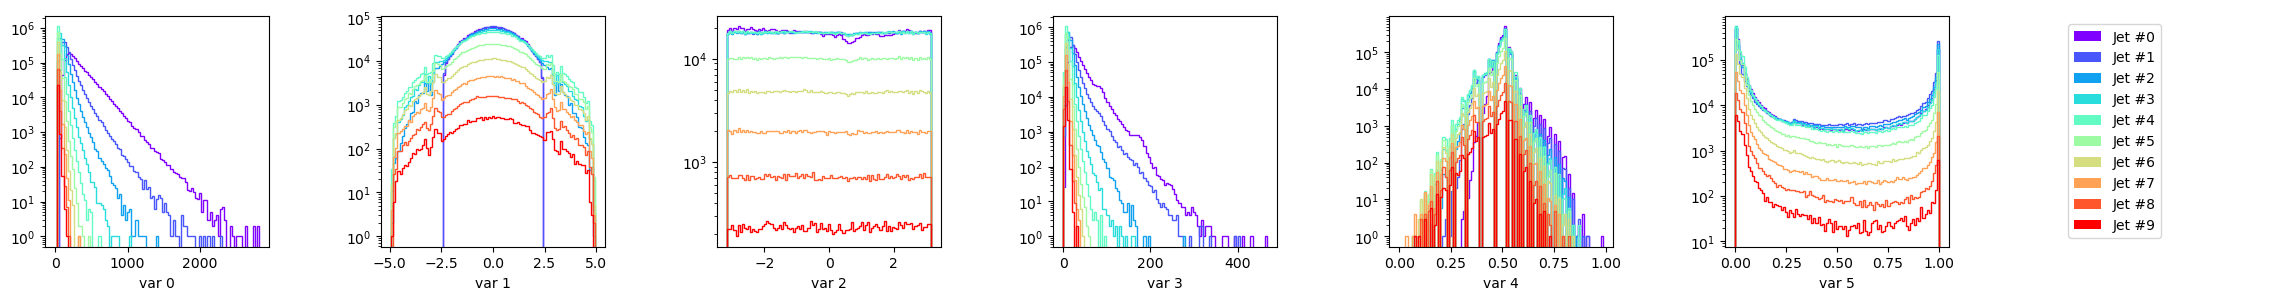

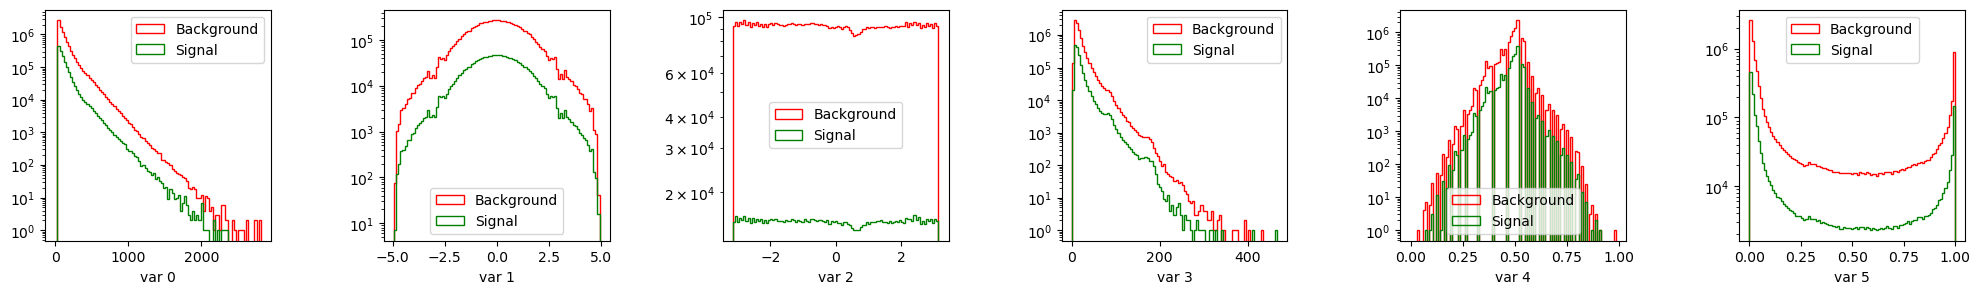

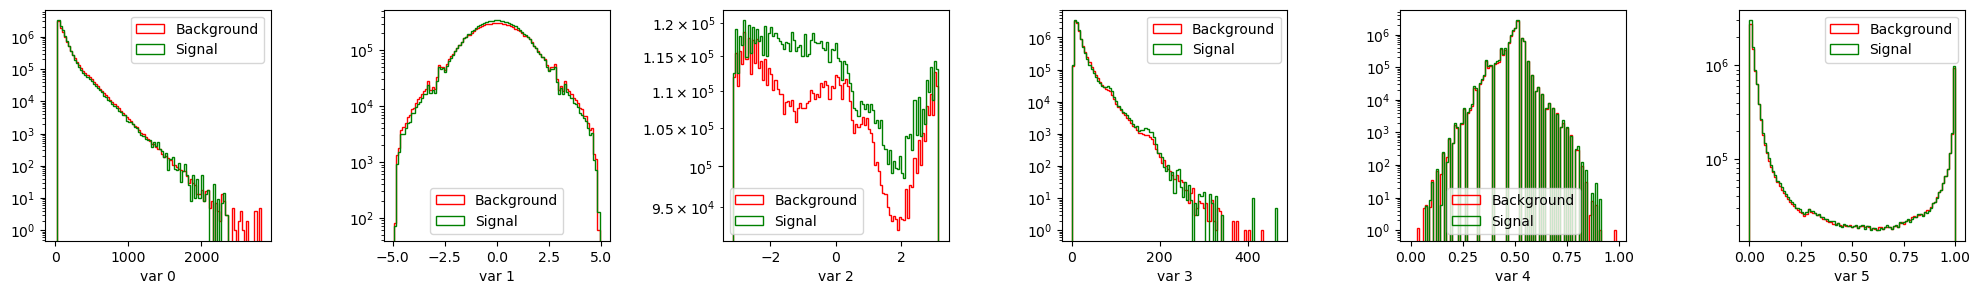

In [3]:
fig = plot_inputs_per_multiplicity(X,y,pad_mask,bins=100,log=True,show=True)
fig = plot_inputs_per_label(X,y,pad_mask,bins=100,log=True,show=True)
fig = plot_inputs_per_label(X,y,pad_mask,bins=100,weights=reweighting,log=True,show=True)

###MULTICLASSIFICATION###
#make a new plot_inputs_per_label function for multiclassification.

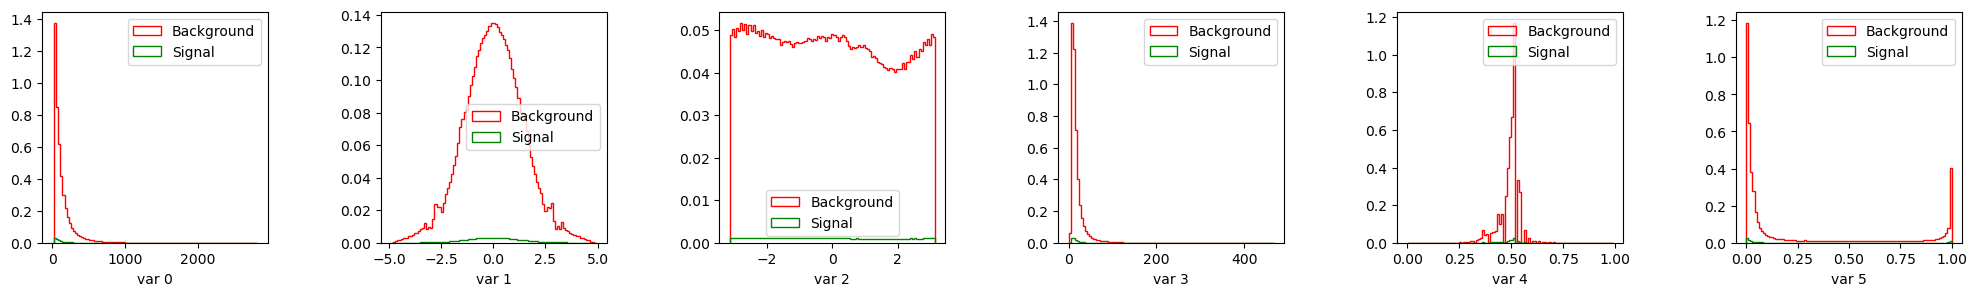

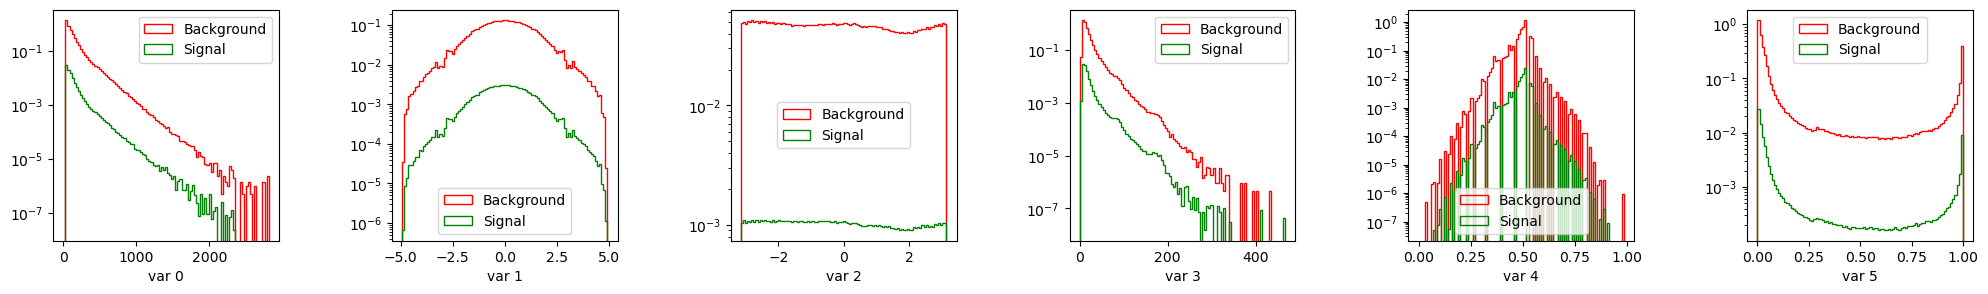

In [4]:
fig = plot_inputs_per_label(X,y,pad_mask,bins=100,weights=weight_nominal_tensor,log=False,show=True)
fig = plot_inputs_per_label(X,y,pad_mask,bins=100,weights=weight_nominal_tensor,log=True,show=True)

# Model
The transformer model can be tweaked with the parameters below (see explanations for each parameter.

The loss function is a composite of BCE, and decorrelation from the MET, to ensure the transformer does not sculpt the latter.

In [5]:
# Define model #

########
#MULTICLASSIFICATION: CrossEntropyLoss??
########



loss_function = BCEDecorrelatedLoss(lam = 0.1,weighted=True)
# loss = BCE + lambda * decorrelated loss 
# lambda = 0 -> pure BCE

# Embedding of the jet features into a higher dimension
embedding = Embedding(
    input_dim = train_X.shape[-1],   # Input dimension
    embed_dims = [64],               # Output dimension
    normalize_input = True,          # Whether to apply batch norm before the embedding
)


#LAYERS:
#Play around with the number of encoder layers, class layers and dnn layers.

model = AnalysisObjectTransformer(
    embedding = embedding,           # Embedding instance 
    embed_dim = embedding.dim,       # Embedding dimension
    num_heads = 8,                   # Number of heads for multihead attention (must be a divisor of embed dim) 
    output_dim = 1,                  # Output dimension (1 : binary classification, >1 : multi classification) 
    expansion_factor = 4,            # Multipliying factor for layers in attention block (neurons = embed_dim * expansion_factor)
    encoder_layers = 5,              # Number of encoder layers (self attention on jets)
    class_layers = 3,                # Number of class layers (cross attention between jets representations and class token)
    dnn_layers = 3,                  # Number of layers for DNN after the transformer
    hidden_activation = nn.GELU,     # Hidden activation in transformer and DNN
    output_activation = None,        # DNN output activation (sigmoid for binary, softmax for multiclass, None if applied in the loss)
    dropout = 0.25,                  # Dropout rate
    loss_function = loss_function,   # Loss function, see above
)

# Print the model graph #
print (model)
# Quick benchmark test the model #
# To make sure the model will run, we take a single batch from the training and pass it through the model

batch = next(iter(train_loader))

inputs, labels, weights, mask, event = batch
print ('Batch dtypes',inputs.dtype,labels.dtype,weights.dtype,mask.dtype,event.dtype)

outputs = model(inputs,padding_mask=mask)
print ('outputs',outputs .shape)
loss_values = loss_function(outputs,labels,event,weights)
print ('losses',loss_values)

AnalysisObjectTransformer(
  (embedding): Embedding(
    (input_bn): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (layers): Sequential(
      (0): Linear(in_features=6, out_features=64, bias=True)
      (1): GELU(approximate='none')
    )
  )
  (encoder_blocks): ModuleList(
    (0-4): 5 x AttBlock(
      (layer_norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (multihead_attention): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
      )
      (layer_norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (layer_norm3): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (linear1): Linear(in_features=64, out_features=256, bias=True)
      (activation): GELU(approximate='none')
      (layer_norm4): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (linear2): Linear(in_features=256, out_features=64, bias=True)
    )
  )
  (class_blocks): M

# Training 

Writing the training loop can involve a biut of boilerplate code. To bypass that we use the [pytorch-lightning](https://lightning.ai/docs/pytorch/stable/) package to run the training. 

The batch steps were defined in the model class, and now we can use the trainer class from lightning to run the training. This takes care of doing the loop, putting data on the GPU if needed, applying the schedule, etc.

One way to finetune our training (or monitor it) is through callbacks. Callbacks are class objects that are evaluated at different times during the training, and allow the user to access their model. Below we use a few of those :
- model checkpoint : saves the best model parameters at every epoch
- early stopping : if the loss values (of the validation) plateau, stops the training (hopefully before overtraining)
- plotting : a plotting callback we wrote to plot the classification metrics at every epoch
- a few other tweaks

Lighting also allows several plotter interface, we use `comet` to log all our metrics (and callback plots) online. You will need an account [here](https://www.comet.com/signup), you can use your github account if you want.

In [ ]:
##### Parameters #####
epochs = 100 #wasw 500
lr = 1e-4

steps_per_epoch_train = math.ceil(len(train_dataset)/train_loader.batch_size)
steps_per_epoch_valid = math.ceil(len(valid_dataset)/valid_loader.batch_size)

print (f'Training   : Batch size = {train_loader.batch_size} => {steps_per_epoch_train} steps per epoch')
print (f'Validation : Batch size = {valid_loader.batch_size} => {steps_per_epoch_valid} steps per epoch')

# Setup optimizer #
optimizer = optim.Adam(model.parameters(), lr=lr)
model.set_optimizer(optimizer)

# Setup scheduler #
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
   optimizer = optimizer,
   mode = 'min', 
   factor = 0.3, 
   patience = 4,               #reduce the learning rate after 10 epochs without improvement
   threshold = 0.,              #threshold for measuring the new optimum
   threshold_mode = 'rel', 
   cooldown = 0, 
   min_lr = 1e-8,               #minimum learning rate
)

model.set_scheduler_config(
    {
        'scheduler' : scheduler,
        'interval' : 'step' if isinstance(scheduler,optim.lr_scheduler.OneCycleLR) else 'epoch',
        'frequency' : 1,
        'monitor' : 'val/loss_tot',
        'strict' : True,
        'name' : 'lr',
    }
)

# Setup callbacks #
checkpoint_callback = ModelCheckpoint(
    dirpath=outdir,  # Directory where checkpoints will be saved
    filename="best-checkpoint",  # Checkpoint filename
    monitor="val/loss_tot",  # Monitor validation loss
    mode="min",  # Save the best model with the minimum validation loss
    save_top_k=1  # Save only the best model
)

early_stopping = EarlyStopping(
    monitor='val/loss_tot',  # Metric to monitor
    patience=30,          # Number of epochs with no improvement after which training will be stopped
    verbose=True,
    mode='min'           # 'min' for loss, 'max' for accuracy
)

log_bar = L.pytorch.callbacks.TQDMProgressBar(refresh_rate=steps_per_epoch_train//100)

plots_callback = EpochEndCallback(
    data = valid_loader,
    frequency = 1,
    subcallbacks = [
        ScoreSubCallback(name='score',bins=100,log=True),
        CorrelationSubCallback(name='corr',bins=100,log=True),
        ROCSubCallback(name='ROC'),
        ConfusionMatrixSubCallback(name='CM'),
    ]
)

## Logger ##
##Commented out for now to avoid large comet log files

# logger = CometLogger(
#     api_key = os.environ.get("COMET_API_KEY"),
#     project_name = "AnalysisObjectTransformer",
#     experiment_name = "Setup",
#     save_dir = "./comet_logs",  # Specify where to save Comet logs if offline
#     offline = False  # Set to True for offline mode
# )

## Trainer ##
trainer = L.Trainer(
    default_root_dir = outdir,
    accelerator = accelerator,
    devices = 1, # Number of GPUs. Notebook only supports 1
    max_epochs = epochs,  # Specify the number of epochs
    log_every_n_steps = steps_per_epoch_train,
    check_val_every_n_epoch = 1,  # Check validation every n epochs
    callbacks = [
        checkpoint_callback, 
        early_stopping,
        log_bar,
        plots_callback,
    ],
    #logger = logger,
    # limit_train_batches = 10,
    # limit_val_batches = 1,
    # limit_test_batches = 1,
)

trainer.fit(
    model = model, 
    train_dataloaders = train_loader, 
    val_dataloaders = valid_loader,
)
trainer.save_checkpoint(f"{outdir}/model.pt")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Training   : Batch size = 1024 => 1390 steps per epoch
Validation : Batch size = 10000 => 36 steps per epoch


/software/da21592/miniconda3/envs/hinv-ml/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
Missing logger folder: model_training/AOTransformer_20250312_170405/lightning_logs
/software/da21592/miniconda3/envs/hinv-ml/lib/python3.12/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory /users/da21592/msci_project/transformer_renewed/bristol-tth-transformer-msc_project/notebooks/model_training/AOTransformer_20250312_170405 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5]



Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/software/da21592/miniconda3/envs/hinv-ml/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=47` in the `DataLoader` to improve performance.
/software/da21592/miniconda3/envs/hinv-ml/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=47` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

AttributeError: 'ExperimentWriter' object has no attribute 'log_figure'

: 

In [ ]:
## Testing model performance on validation set ##
preds = trainer.predict(model=model, dataloaders=valid_loader)
preds = torch.cat(preds, dim=0)

inputs, labels, weights, mask, event = valid_dataset.tensors

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: sklearn, torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5]
/software/da21592/miniconda3/envs/hinv-ml/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=47` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

COMET INFO: The process of logging environment details (conda environment, git patch) is underway. Please be patient as this may take some time.
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml OfflineExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : Setup
COMET INFO:     url                   : [OfflineExperiment will get URL after upload]
COMET INFO:   Others:
COMET INFO:     Created from       : pytorch-lightning
COMET INFO:     Name               : Setup
COMET INFO:     offline_experiment : True
COMET INFO:   Uploads:
COMET INFO:     conda-environment-definition : 1
COMET INFO:     conda-info                   : 1
COMET INFO:     conda-specification          : 1
COMET INFO:     environment details          : 1
COMET INFO:     filename         

In [ ]:
labels.shape,preds.shape

(torch.Size([114908, 1]), torch.Size([114908, 1]))

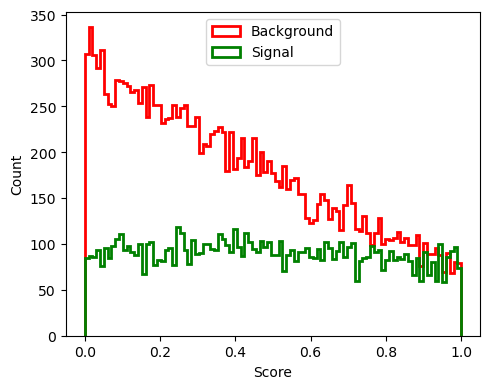

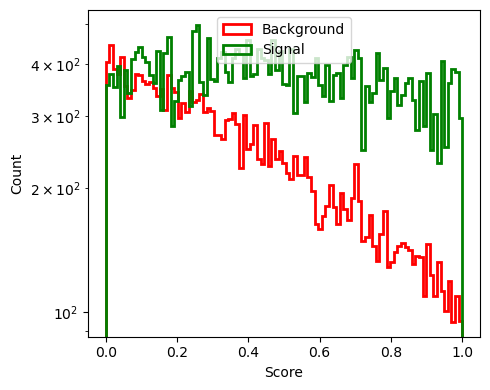

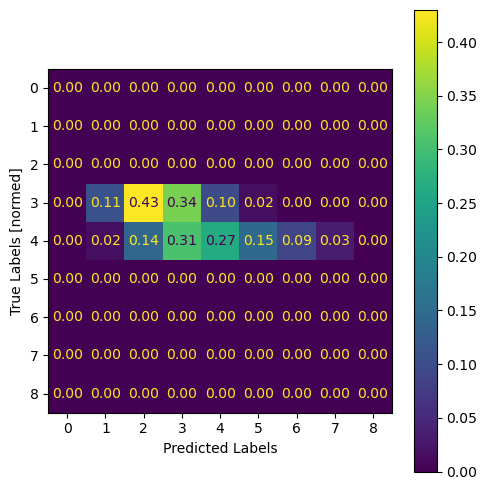

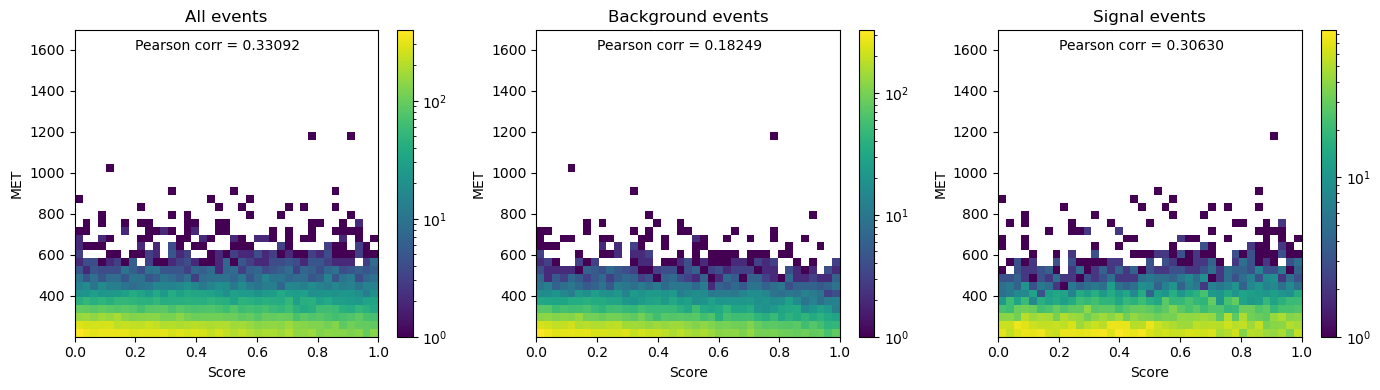

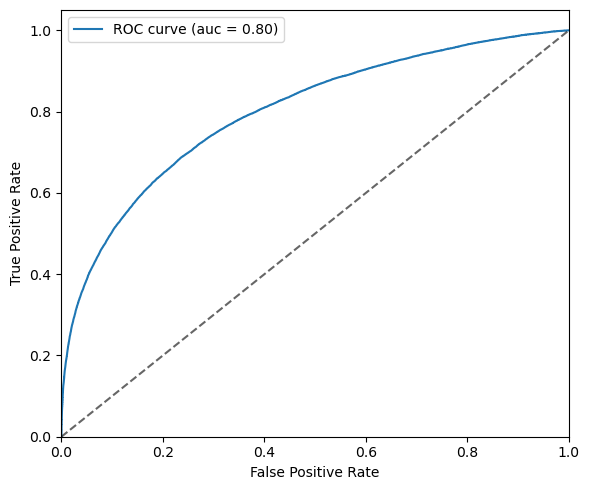

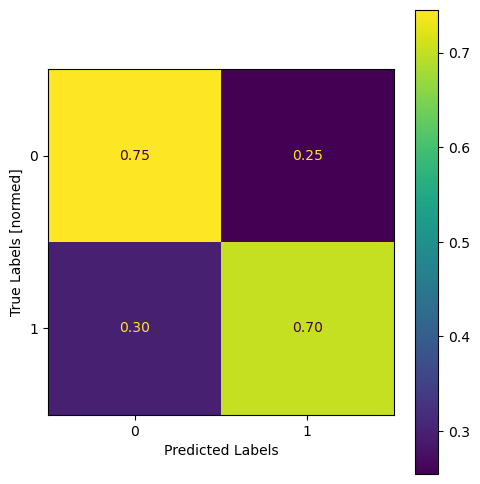

In [ ]:
fig = plot_score(labels,preds,outdir=outdir,bins=100,log=False)
fig = plot_score(labels,preds,weights=weights,outdir=outdir,bins=100,log=True)
fig = plot_confusion_matrix(labels, preds, outdir=outdir,show=True)
fig = plot_correlation(labels,preds,event,outdir=outdir,log=True,bins=40)
fig = plot_roc(labels, preds, outdir=outdir,show=True)


fig = plot_confusion_matrix(labels, torch.sigmoid(preds), outdir=outdir,show=True)

In [ ]:
# %autoreload 2
# fig = plot_confusion_matrix(labels, preds, outdir=outdir,show=True)



No systematic:
Max significance: 7.35
At threshold: 0.920
S: 47.4
B: 41.5

5% systematic:
Max significance: 7.06
At threshold: 0.930
S: 41.1
B: 31.4

10% systematic:
Max significance: 6.40
At threshold: 0.930
S: 41.1
B: 31.4


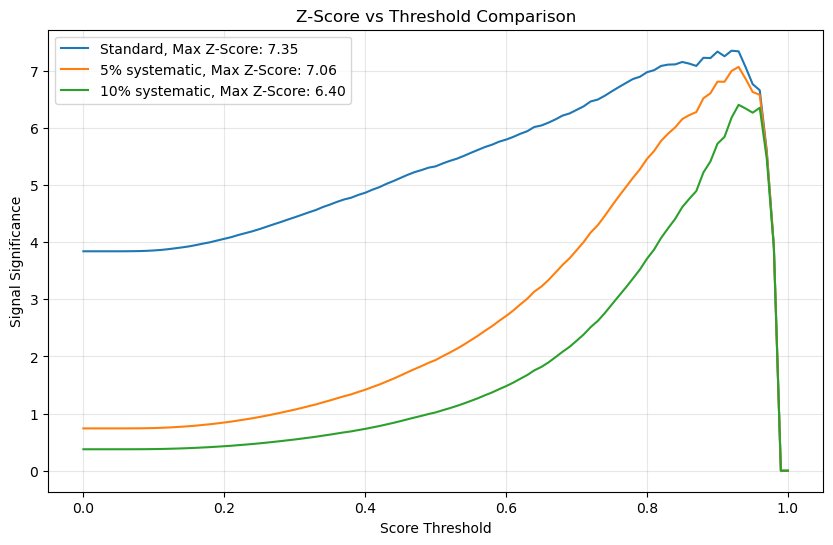

In [ ]:
# Prepare input arrays
event_weights = val_weight_nominal.clone().detach().cpu().numpy().flatten() * 200000
predictions = torch.sigmoid(preds).detach().cpu().numpy().flatten()
truth_labels = labels.detach().cpu().numpy().flatten()  # Convert to numpy

# Initialize arrays
thresh_points = np.linspace(0, 1, 101)
significance_0 = []  # No systematic
significance_5 = []  # 5% systematic
significance_10 = [] # 10% systematic

# Calculate significance vs threshold
for cut in thresh_points:
    # Get events passing threshold using numpy logical operations
    signal_mask = np.logical_and(predictions > cut, truth_labels == 1)
    bkg_mask = np.logical_and(predictions > cut, truth_labels == 0)
    
    # Calculate weighted events
    S = np.sum(event_weights[signal_mask])
    B = np.sum(event_weights[bkg_mask])
    
    # Require minimum events
    if S > 0 and B > 0:
        significance_0.append(S / np.sqrt(B))
        significance_5.append(S / np.sqrt(B + (0.05*B)**2))
        significance_10.append(S / np.sqrt(B + (0.10*B)**2))
    else:
        significance_0.append(0)
        significance_5.append(0)
        significance_10.append(0)





# Find maximum significance values and their indices
max_0 = np.max(significance_0)
max_5 = np.max(significance_5)
max_10 = np.max(significance_10)

idx_0 = np.argmax(significance_0)
idx_5 = np.argmax(significance_5)
idx_10 = np.argmax(significance_10)

# Get thresholds at max significance
thresh_0 = thresh_points[idx_0]
thresh_5 = thresh_points[idx_5]
thresh_10 = thresh_points[idx_10]

# Calculate S and B at these thresholds
for thresh, sig, label in zip([thresh_0, thresh_5, thresh_10], 
                            [max_0, max_5, max_10],
                            ['No systematic', '5% systematic', '10% systematic']):
    signal_mask = np.logical_and(predictions > thresh, truth_labels == 1)
    bkg_mask = np.logical_and(predictions > thresh, truth_labels == 0)
    
    S = np.sum(event_weights[signal_mask])
    B = np.sum(event_weights[bkg_mask])
    
    print(f"\n{label}:")
    print(f"Max significance: {sig:.2f}")
    print(f"At threshold: {thresh:.3f}")
    print(f"S: {S:.1f}")
    print(f"B: {B:.1f}")




fig = plt.figure(figsize=(10,6))

# Plot significance lines
plt.plot(thresh_points, significance_0, label='Standard, Max Z-Score: {:.2f}'.format(max_0))
plt.plot(thresh_points, significance_5, label='5% systematic, Max Z-Score: {:.2f}'.format(max_5))
plt.plot(thresh_points, significance_10, label='10% systematic, Max Z-Score: {:.2f}'.format(max_10))

# Customize plot
plt.xlabel('Score Threshold')
plt.ylabel('Signal Significance')
plt.title('Z-Score vs Threshold Comparison')
plt.grid(alpha=0.3)
plt.legend(loc='upper left')


#show plot
plt.show()


In [ ]:
predictions

array([0.19435365, 0.3083011 , 0.3328831 , ..., 0.45385876, 0.42048532,
       0.2962641 ], dtype=float32)

In [ ]:
#roc_curve(labels, predictions, sample_weight=event_weights)
#weighted_roc_curve(labels, predictions, sample_weights=event_weights)